# Домашнее задание по дисциплине
# "Инструментальные средства моделирования"
## Выполнил:
## МАЛЮТИН А.А. БПМ-152

## Вариант 18
Зона 2 границы детали 𝐹 закреплена, а зона 1 равномерно нагружена усилием 𝑃 (Н/см2) под углом 15∘. Деталь задана следующими размерами: 𝐿,𝐻,𝑊,𝑅 = 15, 5, 2, 7 см и толщиной 𝑡 = 1 см. При условии сохранения упругости деформации определить наибольшую величину усилия 𝑃 , если деталь изготовлена из стали No3.

Коэффициенты стали №3:

E = 220 ГПа

$\mu$ = 0.31

$\sigma_T$ = 900 МПа

![Image of part](./Detail.png)

In [207]:
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
import scipy.optimize
import scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline

## Построение фигуры

Расположим деталь в декартовой систнме координат, так чтобы верхний левый угол оказался в точке (0,0). Сначала построим дуги детали. Верхняя дуга детали будет задаваться дугой окружности с центром в точке $C = \big( \frac{L}{2}, -\frac{H}{2}+ \frac{W}{2}+R\big)$. Найдем точки, в которых эта окружность пересекается с осью абсцисс. Для этого запишем уравнение соответсвующей окружности и решим его относительно x при y=0. 

$$\big(x- \frac{L}{2}\big)^2 + \big(y- \big(  -\frac{H}{2}+ \frac{W}{2}+R\big)\big)^2=R^2$$

При y=0 получаем:

$$x_{1,2}=\frac{L}{2} \pm \sqrt{R^2- \big(  -\frac{H}{2}+ \frac{W}{2}+R\big)^2}$$

In [208]:
L = 15
H = 5
W = 2
R = 7

In [209]:
c11 = -np.sqrt(R**2-(-H/2+W/2+R)**2)+L/2
c11

3.1698729810778064

In [210]:
c12 = np.sqrt(R**2-(-H/2+W/2+R)**2)+L/2
c12

11.830127018922195

Рассмторим треугольник с вершинами в точках С, A = ($x_2$,0), B = ($x_1$,0)

Text(7.5,5.5,'C - центр окружности')

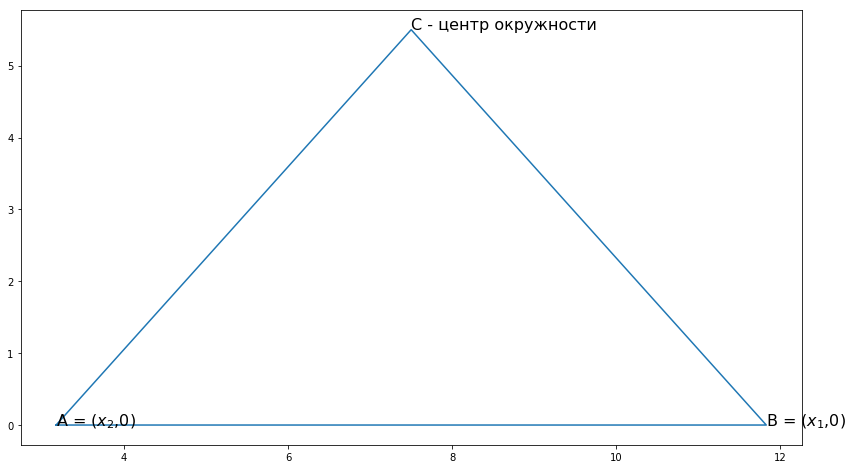

In [211]:
plt.figure(figsize=(14,8))
plt.plot([c11,L/2,c12,c11],[0,-H/2+W/2+R,0,0])
plt.text(c11,0,'A = ($x_2$,0)',fontsize=16)
plt.text(c12,0,'B = ($x_1$,0)',fontsize=16)
plt.text(L/2,-H/2+W/2+R,'C - центр окружности',fontsize=16)

Это равнобедренный треугольник со сторонами AC=AB=R, AB = $x_1-x_2$.

Тогда $\angle ABC = 2arcsin\left(\frac{|AB|}{2R} \right)$

In [212]:
deg = np.degrees(2*np.arcsin((c12-c11)/(2*R)))
deg

76.42642140347641

In [213]:
R1 = c12-c11

Таким образом нашли углы дуг детали. Теперь, зная их центры, легко построить эти дуги.

In [214]:
def create_arc(c, r, a1, a2, s):
    alpha = np.radians(np.linspace(a1, a2, s))
    x = r*np.cos(alpha) + c[0]
    y = r*np.sin(alpha) + c[1]
    
    return np.hstack((x.reshape(-1, 1),y.reshape(-1, 1)))

In [215]:
split_arc1 = create_arc([L/2,-H/2+W/2+R], R, 270 + deg/2, 270 - deg/2, 25)
split_arc2 = create_arc([L/2,-H/2-W/2-R], R, 90 + deg/2, 90 - deg/2, 25)

In [216]:
def show_parts(*parts, **kwargs):
    plt.figure(figsize=(14,8))
    plt.grid(True)
    plt.axis('equal')
    for part in parts:
        plt.plot(part[:,0],part[:,1], 'o', c='r')

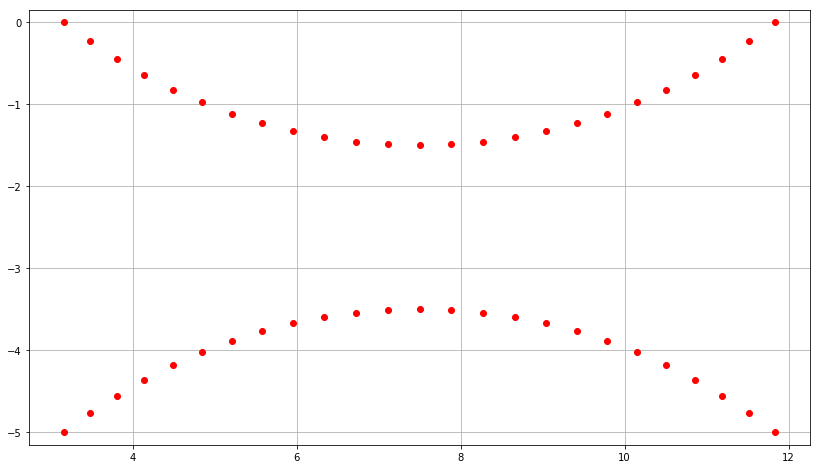

In [217]:
show_parts(split_arc1, split_arc2)

Построение остальной части фигуры - тривиально.

In [218]:
def split_border(Nodes,N,closed=False):
    points_x = np.array([])
    points_y = np.array([])
    for i in range(Nodes.shape[0]-2):
        points_x = np.append(points_x, np.linspace(Nodes[i,0],Nodes[i+1,0],N[i])[:-1])
        points_y = np.append(points_y,np.linspace(Nodes[i,1],Nodes[i+1,1],N[i])[:-1])
        
    if not closed:   
        points_x = np.append(points_x,np.linspace(Nodes[-2,0],Nodes[-1,0],N[-1]))
        points_y = np.append(points_y,np.linspace(Nodes[-2,1],Nodes[-1,1],N[-1]))
    if closed:
        points_x = np.append(points_x,np.linspace(Nodes[-2,0],Nodes[-1,0],N[-1])[:-1])
        points_y = np.append(points_y,np.linspace(Nodes[-2,1],Nodes[-1,1],N[-1])[:-1])
    
    
    return np.hstack((points_x.reshape(-1,1),points_y.reshape(-1,1)) )

In [219]:
stp = [split_arc1[-1][0],0]

In [220]:
stp2 = [split_arc2[-1][0],-H]

In [221]:
bbord = np.array([stp,
         [stp[0]-(L-R1)/2,stp[1]],
         [stp[0]-(L-R1)/2,stp[1]-H],
         [stp[0],stp[1]-H]])
fbord = np.array([stp2,
                 [stp2[0]+(L-R1)/2,stp2[1]],
                 [stp2[0]+(L-R1)/2,stp2[1]+H],
                 [stp2[0],stp2[1]+H]])

In [222]:
split_bbord = split_border(bbord,[10,14,10])[1:-1]
split_fbord = split_border(fbord,[10,14,10])[1:-1]

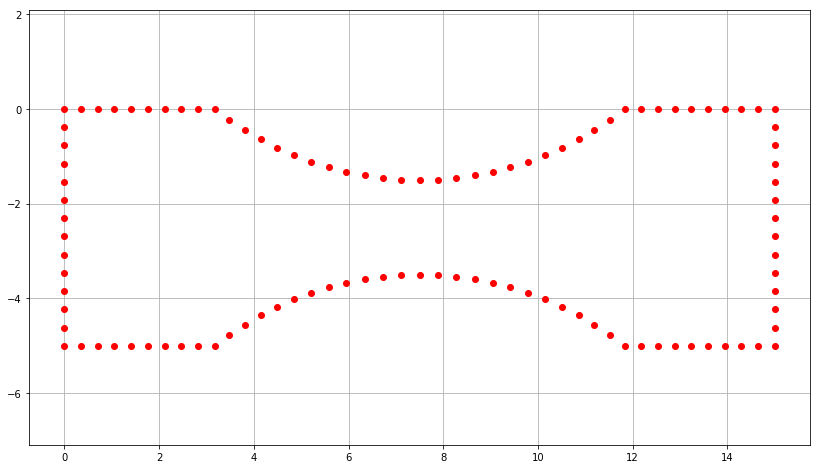

In [223]:
show_parts(split_arc1,split_bbord,split_arc2,split_fbord)

In [224]:
border = np.vstack((split_arc1,split_bbord,split_arc2,split_fbord))

## Построение триангуляции

In [225]:
delta = 0.25

In [226]:
X,Y = np.meshgrid(np.linspace(delta,L-delta,39),np.linspace(0-delta,-H+delta,13))

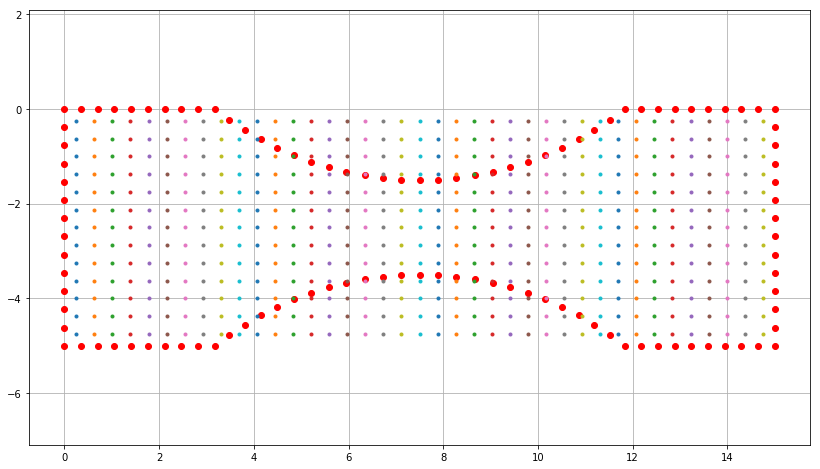

In [227]:
show_parts(border)
plt.plot(X,Y,'.');

In [228]:
inner = np.vstack((X.ravel(),Y.ravel())).T
inner.shape

(507, 2)

In [229]:
delta2 = 0.1

In [230]:
mask1 = np.sum((inner-np.array([L/2,-H/2+W/2+R]))**2,axis=1) > (R+delta2)**2
mask2 = np.sum((inner-np.array([L/2,-H/2-W/2-R]))**2,axis=1) > (R+delta2)**2

In [231]:
inner = inner[mask1 & mask2]

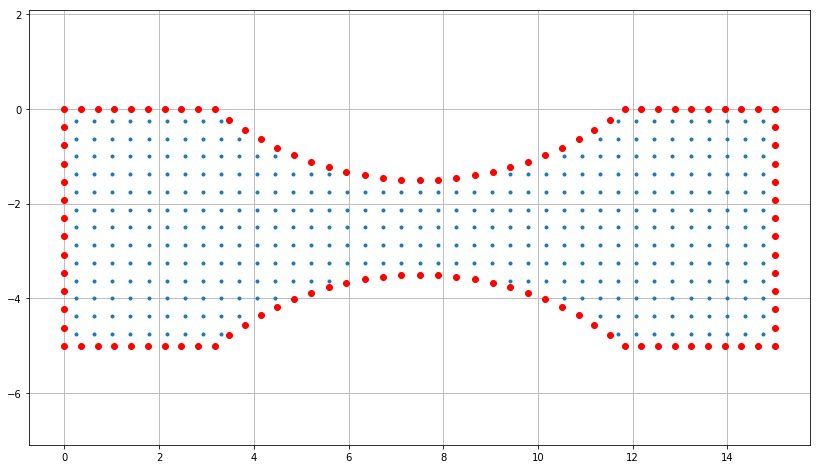

In [232]:
show_parts(border)
plt.plot(inner[:,0],inner[:,1],'.')

In [233]:
Nodes = np.vstack((border,inner))

In [234]:
Nodes.shape

(489, 2)

In [235]:
trng = scipy.spatial.Delaunay(Nodes)

(-0.7499999999999991, 15.75, -5.250000000000002, 0.2500000000000029)

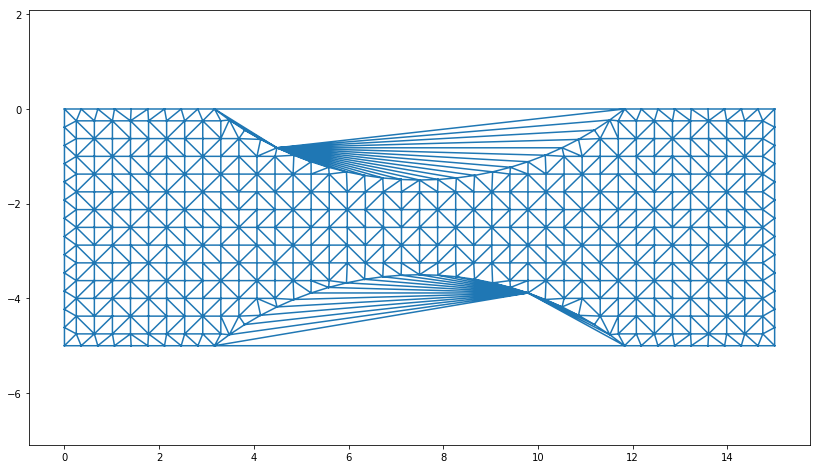

In [236]:
plt.figure(figsize=(14,8))
plt.triplot(Nodes[:,0],Nodes[:,1],trng.simplices.copy())
plt.axis('equal')

In [237]:
trng_vertices = Nodes[trng.simplices]

In [238]:
trng_x_verices = trng_vertices[:,:,0]

In [239]:
trng_y_verices = trng_vertices[:,:,1]

In [240]:
trng_x_mean = np.mean(trng_x_verices,axis=1)
trng_y_mean = np.mean(trng_y_verices,axis=1)

In [241]:
trng_centers = np.hstack((trng_x_mean.reshape(-1,1),trng_y_mean.reshape(-1,1)))

In [242]:
delta2 = 0.01
mask_tri1 = np.sum((trng_centers - np.array([L/2,-H/2+W/2+R]))**2, axis=1) > (R+delta2)**2
mask_tri2 = np.sum((trng_centers - np.array([L/2,-H/2-W/2-R]))**2, axis=1) > (R+delta2)**2

In [243]:
simplices = trng.simplices.copy()
simplices = simplices[mask_tri1 & mask_tri2]

(-0.7499999999999991, 15.75, -5.250000000000002, 0.2500000000000029)

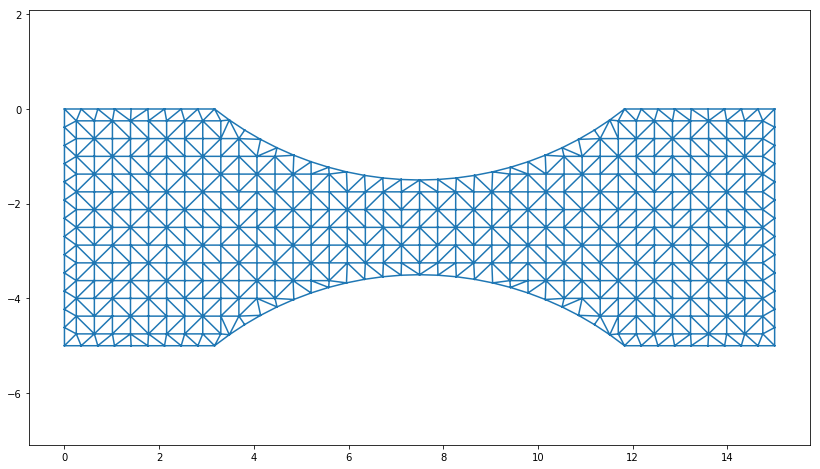

In [244]:
plt.figure(figsize=(14,8))
plt.triplot(Nodes[:,0],Nodes[:,1],simplices)
plt.axis('equal')

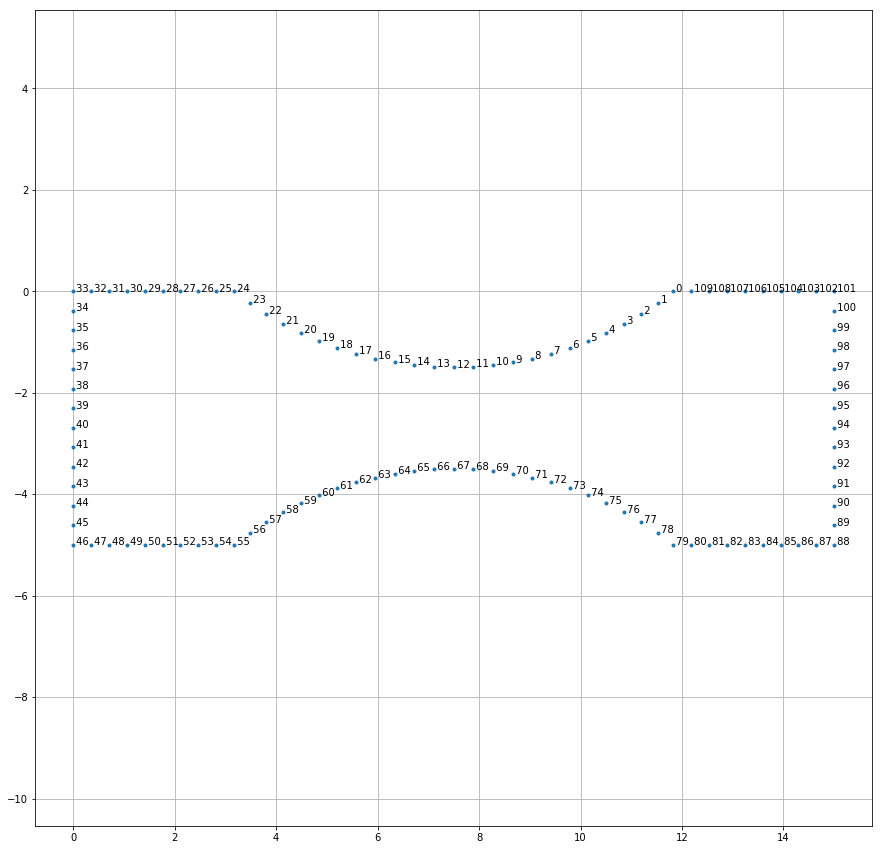

In [245]:
plt.figure(figsize=(15,15))
plt.plot(border[:,0], border[:,1], '.')
for i, p in enumerate(border):
    plt.text(p[0], p[1], ' %d'%i)
plt.axis('equal')
plt.grid(True)

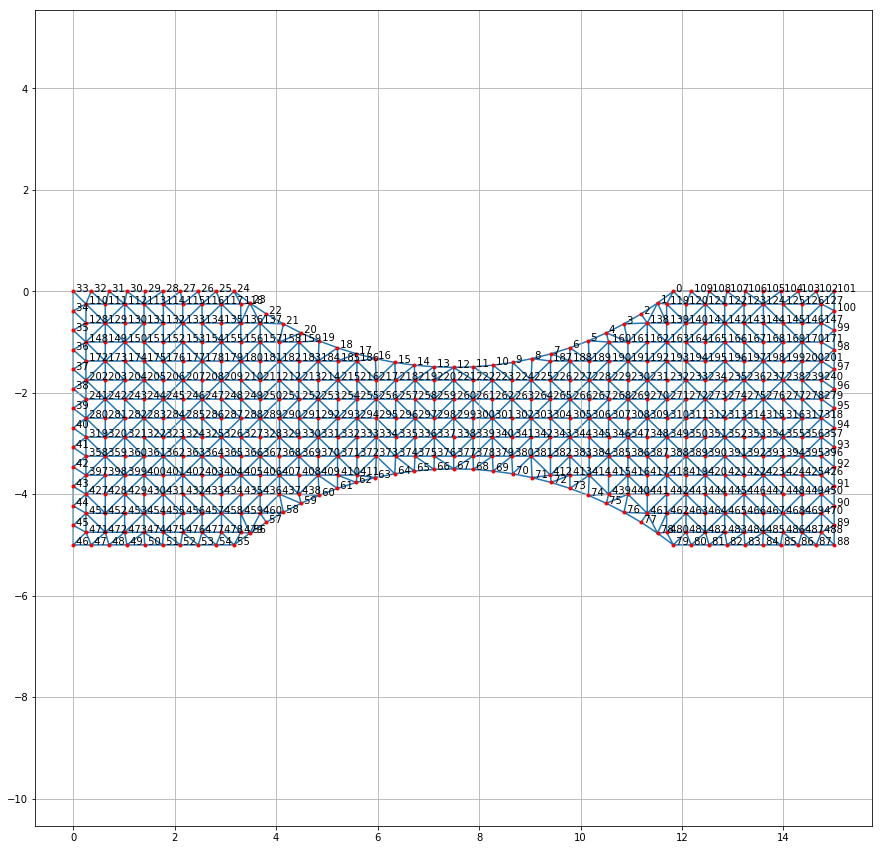

In [246]:
plt.figure(figsize=(15,15))
plt.triplot(Nodes[:,0],Nodes[:,1],simplices)
plt.plot(Nodes[:,0],Nodes[:,1],'.',c='r')
for i, p in enumerate(Nodes):
    plt.text(p[0], p[1], ' %d'%i)
plt.axis('equal')
plt.grid(True)

In [247]:
def triarea(a, b, c):
    ab = b - a
    ac = c - a
    return 0.5 * (ab[:,0]*ac[:,1] - ab[:,1]*ac[:,0])

In [248]:
def FEM(nodes, simplices,e,mu,t,p,fixed_elems,force_elems,x_alpha,y_alpha):
    # расчет матрицы градиентов
    trng_vertices2 = nodes[simplices] # Пересчитаем, т.к. надо учитывать маски
    A = triarea(trng_vertices2[:,0], trng_vertices2[:,1], trng_vertices2[:,2])
    b = trng_vertices2[:, [1,2,0], 1] - trng_vertices2[:, [2, 0, 1], 1]
    c = trng_vertices2[:, [2,0,1],0] - trng_vertices2[:,[1,2,0],0]
    z = np.zeros_like(b[:,0])
    B1 = np.stack((b[:,0], z, b[:,1], z, b[:,2], z), axis=1)
    B2 = np.stack((z, c[:,0], z, c[:,1], z, c[:,2]), axis=1)
    B3 = np.stack((c[:,0], b[:,0], c[:,1], b[:,1], c[:,2], b[:,2]), axis=1)
    B = np.stack((B1, B2, B3), axis=1)
    
    # расчет глобальной матрицы жесткости
    coef = 1/(2*A)
    B *= coef.reshape(-1, 1, 1)
    D = e / (1 - mu**2)*np.array([[1,mu,0], [mu,1,0], [0,0,0.5*(1-mu)]])
    BT = np.transpose(B, axes=(0,2,1))
    Ke = np.matmul(np.matmul(BT, D), B)*t*A.reshape(-1, 1, 1)
    coords0 = simplices[:, 0].reshape(-1, 1)
    coords1 = simplices[:, 1].reshape(-1, 1)
    coords2 = simplices[:, 2].reshape(-1, 1)
    EFT = np.hstack((coords0*2, coords0*2+1, coords1*2, coords1*2+1, coords2*2, coords2*2+1))
    Nn = Nodes.shape[0]
    K = np.zeros((2*Nn, 2*Nn))
    for i in range(simplices.shape[0]):
        K[EFT[i, np.newaxis].T,EFT[i]] += Ke[i]
    dof = np.hstack((fixed_elems*2, fixed_elems*2+1))
    K[dof,:] = 0
    K[:,dof] = 0
    K[dof,dof] = 1
    
    # расчет силы, действующей на элементы
    F = np.zeros(2*Nn)
    edges_L = np.sqrt(np.sum((nodes[force_elems[1:]]-nodes[force_elems[:-1]])**2,axis=1))
    edges_F = edges_L * t * p
    if np.abs(np.cos(x_alpha))>1e-10:
        F[force_elems[1: ]*2]+=0.5*edges_F*np.cos(x_alpha)
        F[force_elems[:-1]*2]+=0.5*edges_F*np.cos(x_alpha)
        
    if np.abs(np.cos(y_alpha))>1e-10:
        F[force_elems[1: ]*2+1]+=0.5*edges_F*np.cos(y_alpha)
        F[force_elems[:-1]*2+1]+=0.5*edges_F*np.cos(y_alpha)
    
    F[dof] = 0
    
    # расчет перемещений
    U = np.linalg.solve(K, F)
    
    # расчет напряжений и главных напряжений
    Ue = U[EFT, None]
    Eps = np.matmul(B, Ue)
    Sig = np.matmul(D, Eps)
    NodeA = np.zeros((Nn,1))
    NodeSig = np.zeros((Nn,3))
    for i, e in enumerate(simplices):
        NodeSig[e] += Sig[i].T*A[i]
        NodeA[e] += A[i]
    NodeSig /= NodeA
    NodeS1 = 0.5*(NodeSig[:,0]+NodeSig[:,1])+\
         np.sqrt((0.5*(NodeSig[:,0]-NodeSig[:,1]))**2+NodeSig[:,2]**2)
    
    return U, NodeS1

In [249]:
def plot_abs_contour_map(ResNodes, NodeS1,fixed_elems,force_elems):
    newNodeS1 = np.abs(NodeS1)
    i_max = np.argmax(np.abs(NodeS1))
    i_min = np.argmin(NodeS1)
    plt.figure(figsize=(16,8))
    levels = np.linspace(0, newNodeS1[i_max], 20)
    handle = plt.tricontourf(ResNodes[:,0], ResNodes[:, 1], simplices, newNodeS1.ravel(), cmap='jet',levels=levels)
    plt.tricontour(ResNodes[:, 0], ResNodes[:, 1], simplices, 
                  newNodeS1.ravel(), colors='k', levels=levels)
    plt.plot(border[:,0],border[:,1],'r','-')
    plt.plot(ResNodes[i_max,0], ResNodes[i_max,1], '.r')
    plt.text(ResNodes[i_max,0], ResNodes[i_max,1], ' %.2f'%newNodeS1[i_max],fontsize=20)
    plt.plot(ResNodes[i_min,0], ResNodes[i_min,1], '.r')
    plt.text(ResNodes[i_min,0], ResNodes[i_min,1], ' %.2f'%newNodeS1[i_min],fontsize=20)
    
    for elem in fixed_elems:
        plt.plot(ResNodes[elem,0],ResNodes[elem,1],'.k')
        plt.text(ResNodes[elem,0],ResNodes[elem,1],'({}) {:.2f}'.format(elem,newNodeS1[elem]),fontsize=12)
    
    for elem in force_elems:
        plt.plot(ResNodes[elem,0],ResNodes[elem,1],'.r')
        plt.text(ResNodes[elem,0]-2.5,ResNodes[elem,1],'({}) {:.2f}'.format(elem,newNodeS1[elem]),fontsize=12)
    
    cb = plt.gcf().colorbar(handle)
    cb.set_ticks(levels)
    plt.title('Поле главных напряжений (по модулю) в узлах, Н/см$^2$')
    plt.xlabel('X, см')
    plt.ylabel('Y, см')
    plt.axis('equal')
    plt.ylim((-11.5,0.5))

In [250]:
def plot_contour_map(ResNodes, NodeS1,fixed_elems,force_elems):
    i_max = np.argmax(np.abs(NodeS1))
    i_min = np.argmin(NodeS1)
    plt.figure(figsize=(16,8))
    levels = np.linspace(NodeS1[i_min], NodeS1[i_max], 20)
    handle = plt.tricontourf(ResNodes[:,0], ResNodes[:, 1], simplices, NodeS1.ravel(), cmap='jet',levels=levels)
    plt.tricontour(ResNodes[:, 0], ResNodes[:, 1], simplices, 
                  NodeS1.ravel(), colors='k', levels=levels)
    plt.plot(border[:,0],border[:,1],'r','-')
    plt.plot(ResNodes[i_max,0], ResNodes[i_max,1], '.r')
    plt.text(ResNodes[i_max,0], ResNodes[i_max,1], ' %.2f'%NodeS1[i_max],fontsize=20)
    plt.plot(ResNodes[i_min,0], ResNodes[i_min,1], '.r')
    plt.text(ResNodes[i_min,0], ResNodes[i_min,1], ' %.2f'%NodeS1[i_min],fontsize=20)
    
    for elem in fixed_elems:
        plt.plot(ResNodes[elem,0],ResNodes[elem,1],'.k')
        plt.text(ResNodes[elem,0],ResNodes[elem,1],'({}) {:.2f}'.format(elem,NodeS1[elem]),fontsize=12)
    
    for elem in force_elems:
        plt.plot(ResNodes[elem,0],ResNodes[elem,1],'.r')
        plt.text(ResNodes[elem,0]-2.5,ResNodes[elem,1],'({}) {:.2f}'.format(elem,NodeS1[elem]),fontsize=12)
    
    cb = plt.gcf().colorbar(handle)
    cb.set_ticks(levels)
    plt.title('Поле главных напряжений в узлах, Н/см$^2$')
    plt.xlabel('X, см')
    plt.ylabel('Y, см')
    plt.axis('equal')
    plt.ylim((-11.5,0.5))

## Решение оптимизационной задачи

In [251]:
fixed = np.arange(88,101)
forced = np.arange(33,46)

In [252]:
def func(p):
    U, S1 = FEM(Nodes,simplices,e=2e7,mu=0.27,t=1,p=p,fixed_elems=fixed,force_elems=forced,x_alpha=3*np.pi/2,y_alpha=np.pi)
    return np.max(np.abs(S1))

$\sigma_T=900 МПа = 9 \cdot 10^4 \frac{Н}{см^2}$

In [253]:
sT = 3e4

In [254]:
max_P = scipy.optimize.root(lambda p:(func(p)-sT), 1e5)['x'][0]
max_P

644.545923441584

In [255]:
U, NodeS1 = FEM(Nodes,simplices,e=2e7,mu=0.27,t=1,p=max_P,fixed_elems=fixed,force_elems=forced,x_alpha=3*np.pi/2,y_alpha=np.pi)

In [256]:
scale = 20

In [257]:
ResNodes = Nodes + scale*U.reshape(-1, 2)

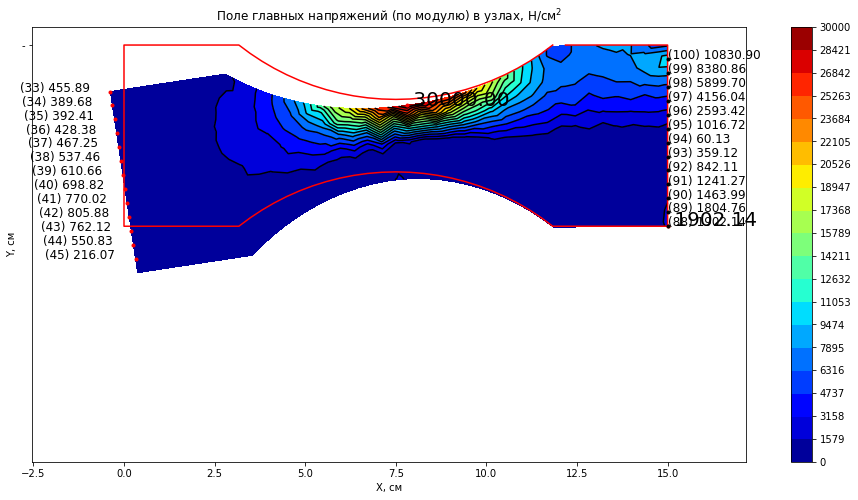

In [258]:
plot_abs_contour_map(ResNodes,NodeS1,fixed,forced) # по модулю

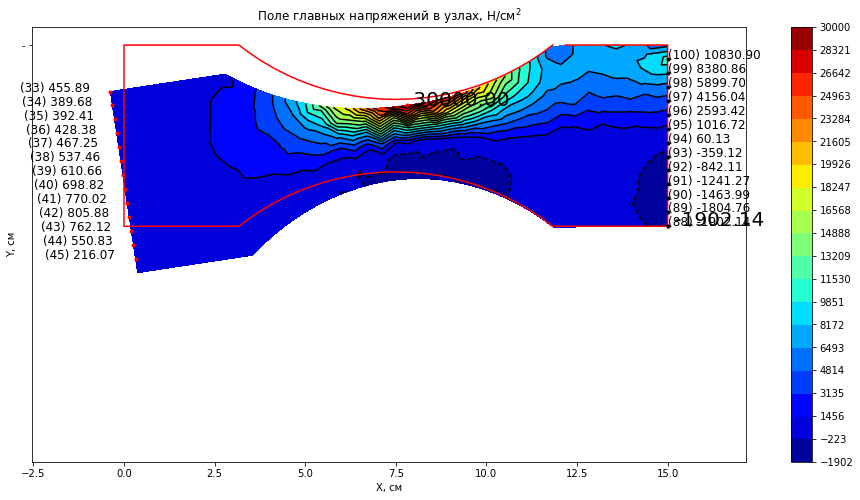

In [259]:
plot_contour_map(ResNodes,NodeS1,fixed,forced) # по истинному значению